This tutorial shows how the STiMetaD class can be used for kinetics inference through the Short-Time Infrequent Metadynamics method. When initiating the class, one can set the minimal number of samples used for the inference. The default value is 5.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from STiMetaD import STiMetaD

estimator = STiMetaD(minSampleSize = 5)

We use data of Metadynamics simulations of alanine dipeptide, biasing the suboptimal $\psi$ angle as collective variable at different deposition rates.
Each data csv file contains three columns: the simulation time, the acceleration factor and the rescaled time.

All functions of the STiMetaD class require a numpy array of rescaled first-passage times. Here, we provide it with the appropriate column of the data csv file ("predicted"). The STiMetaD class provides estimations for the mean first-passage time (MFPT), the kinetic rate and $t^*$. Below, we obtain estimations for simulations with a bias pace of 20 ps, in units of $\mu s$ or $\mu s ^ {-1}$.

In [2]:
data = pd.read_csv("alanineDipeptide/psi20.csv")
samples = np.array(data.predicted)
print(f"MFPT: {estimator.estimateMFPT(samples = samples) / 1e6}, "\
      f"k: {estimator.estimateRate(samples = samples) * 1e6}, "\
      f"t*: {estimator.estimateTstar(samples = samples) / 1e6}")

MFPT: 5.0546241896400215, k: 0.19783864486891112, t*: 0.184311499096


We can choose other values for the minimal numbers of samples,
by setting the minSampleSize parameter.

In [3]:
print(f"MFPT (minimum 5 samples): {estimator.estimateMFPT(samples = samples) / 1e6}, "\
      f"MFPT (minimum 50 samples): {estimator.estimateMFPT(samples = samples, minSampleSize = 50) / 1e6}")

MFPT (minimum 5 samples): 5.0546241896400215, MFPT (minimum 50 samples): 8.398149074709304


We can also obtain a pandas dataframe with estimations of the kinetic rates for different choices of $t^*$. It also gives $R^2$ for each estimation.

In [4]:
print(estimator.obtainEstimationsDataFrame(samples = samples, minSampleSize = 5)[:10])

          Tstar    prediction        R2
0  33849.311881  1.391923e-07  0.805184
1  34869.917104  1.431131e-07  0.885909
2  41944.413164  1.525084e-07  0.903221
3  45725.439924  1.572324e-07  0.929170
4  49134.368885  1.622596e-07  0.941932
5  54918.959304  1.674673e-07  0.947387
6  62037.590678  1.710456e-07  0.955537
7  62251.465158  1.726921e-07  0.964751
8  68237.711000  1.766459e-07  0.964608
9  80602.464350  1.794084e-07  0.967944


Lastly, the class can also give the standard iMetaD estimation, and the p-value of a Kolmogorov–Smirnov test. The number of samples from the fitted exponential distribution is adjustable.

In [5]:
print(f"MFPT (iMetaD): {estimator.iMetaDMFPT(samples = samples) }, "\
      f"k (iMetaD): {estimator.iMetaDrate(samples = samples) }, "\
      f"MFPT, p-value: {estimator.iMetaDMFPT(samples = samples, KStest = True, fitSamples = 1000000) }, "\
      f"k, p-value: {estimator.iMetaDrate(samples = samples, KStest = True, fitSamples = 1000000) }")

MFPT (iMetaD): 33191796.97649364, k (iMetaD): 3.012792590615681e-08, MFPT, p-value: (33191796.97649364, 1.8836615120202843e-26), k, p-value: (3.012792590615681e-08, 2.311389185427692e-26)


Below, we reproduce Figures 2, 3(a,b), and 4(b) to demontrate the use of the class.

/home/ofirblumer/Projects/resetting/iMetaDpaper/STiMetaD/STiMetaD.py:20: RuntimeWarning: overflow encountered in exp
  return 1-np.exp(-t / a)


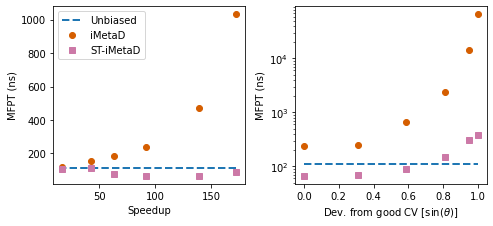

In [6]:
unbiased = 110372.643984 # Unbiased MFPT in ps

fig, axs = plt.subplots(1, 2, figsize=(7., 3.25))

paces = [1, 2, 5, 10, 20, 100]
angles = np.array([0, 18, 36, 54, 72, 90])

speedups = []
iMetaDpredictions = []
STiMetaDpredictions = []

for pace in paces:
    data = pd.read_csv(f"WolfeQuapp/0_{pace}.csv")
    samples = np.array(data.predicted)

    iMetaDpredictions.append(estimator.iMetaDMFPT(samples = samples) / 1e3)
    STiMetaDpredictions.append(estimator.estimateMFPT(samples = samples) / 1e3)
    speedups.append(unbiased / data.time.mean())

axs[0].plot(speedups, [unbiased / 1e3 for speedup in speedups], linestyle="dashed",linewidth=2)
axs[0].plot(speedups, iMetaDpredictions, "o", c='#D55E00')
axs[0].plot(speedups, STiMetaDpredictions, "s", c='#CC79A7') 
axs[0].set_xlabel("Speedup")
axs[0].set_ylabel("MFPT (ns)")

iMetaDpredictions = []
STiMetaDpredictions = []

for angle in angles:
    data = pd.read_csv(f"WolfeQuapp/{angle}_5.csv")
    samples = np.array(data.predicted)

    iMetaDpredictions.append(estimator.iMetaDMFPT(samples = samples) / 1e3)
    STiMetaDpredictions.append(estimator.estimateMFPT(samples = samples) / 1e3)

axs[1].plot(np.sin(angles * np.pi / 180), [unbiased / 1e3 for speedup in speedups], linestyle="dashed", linewidth=2)
axs[1].plot(np.sin(angles * np.pi / 180), iMetaDpredictions, "o", c='#D55E00')
axs[1].plot(np.sin(angles * np.pi / 180), STiMetaDpredictions, "s", c='#CC79A7') 
axs[1].set_xlabel(r"Dev. from good CV [sin($\theta$)]")
axs[1].set_ylabel("MFPT (ns)")

axs[0].legend(["Unbiased", "iMetaD", "ST-iMetaD"], loc="upper left")
axs[1].set_yscale("log")
fig.tight_layout()

/home/ofirblumer/Projects/resetting/iMetaDpaper/STiMetaD/STiMetaD.py:20: RuntimeWarning: overflow encountered in exp
  return 1-np.exp(-t / a)


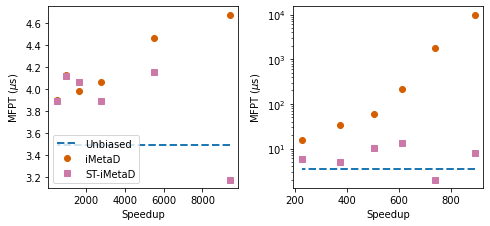

In [7]:
unbiased = 3494120 # Unbiased MFPT in ps

fig, axs = plt.subplots(1, 2, figsize=(7., 3.25))
CVs = ["phi", "psi"]
paces = [1, 2, 5, 10, 20, 50]

for i in range(2):
    speedups = []
    iMetaDpredictions = []
    STiMetaDpredictions = []

    for pace in paces:
        data = pd.read_csv(f"alanineDipeptide/{CVs[i]}{pace}.csv")
        samples = np.array(data.predicted)

        iMetaDpredictions.append(estimator.iMetaDMFPT(samples = samples) / 1e6)
        STiMetaDpredictions.append(estimator.estimateMFPT(samples = samples) / 1e6)
        speedups.append(unbiased / data.time.mean())

    axs[i].plot(speedups, [unbiased / 1e6 for speedup in speedups], linestyle="dashed", linewidth=2)
    axs[i].plot(speedups, iMetaDpredictions, "o", c='#D55E00')
    axs[i].plot(speedups, STiMetaDpredictions, "s", c='#CC79A7') 
    axs[i].set_xlabel("Speedup")
    axs[i].set_ylabel(r"MFPT ($\mu$s)")

axs[0].legend(["Unbiased", "iMetaD", "ST-iMetaD"], loc="lower left")
axs[1].set_yscale("log")
fig.tight_layout()

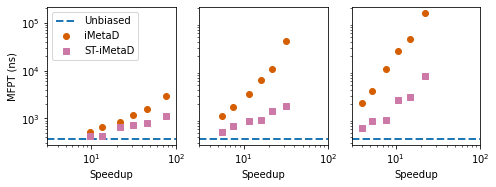

In [8]:
unbiased = 3.76e5 # Unbiased MFPT in ps

fig, axs = plt.subplots(1, 3, figsize=(7., 2.7))
paces = [20, 50, 100, 200, 500, 1000]
CVs = ["HLDA", "Rg", "RMSD"]

for i in range(3):
    speedups = []
    iMetaDpredictions = []
    STiMetaDpredictions = []

    for pace in paces:
        data = pd.read_csv(f"chignolin/{CVs[i]}{pace}.csv")
        samples = np.array(data.predicted)

        iMetaDpredictions.append(estimator.iMetaDMFPT(samples = samples) / 1e3)
        STiMetaDpredictions.append(estimator.estimateMFPT(samples = samples) / 1e3)
        speedups.append(unbiased / data.time.mean())

    axs[i].plot([3, 100], [unbiased / 1e3, unbiased / 1e3], linestyle="dashed", linewidth=2)
    axs[i].plot(speedups, iMetaDpredictions, "o", c='#D55E00')
    axs[i].plot(speedups, STiMetaDpredictions, "s", c='#CC79A7') 
    axs[i].set_xlabel("Speedup")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].set_xlim(3, 100)

axs[0].legend(["Unbiased", "iMetaD", "ST-iMetaD"], loc="upper left")
for i in range(1,3):
    axs[i].set_yticks([])
    axs[i].set_yticks([])
for i in range(3):
    axs[i].set_ylim(min([axs[j].get_ylim()[0] for j in range(3)]), max([axs[j].get_ylim()[1] for j in range(3)]))
axs[0].set_ylabel(r"MFPT (ns)")
fig.tight_layout()